# Prediction of Airline Flight Delays during Holiday periods

In [825]:
import pandas as pd
import numpy as np
import requests
from StringIO import StringIO
import json
import glob
import seaborn as sns

import time
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

The dataset for airline data was obtained [here](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time). The goal of my project is to see if I can

1. Predict the probability a flight will be delayed given some features\n
2. Given that a flight is delayed, predict by how much the flight will be delayed by given these features.

The features I will be using for this prototype are:

1. Airport Code (ORD, ATL, SFO, LAX)
2. Time of flight (Morning between 5am and noon, Afternoon between noon and 7pm, evening between 7pm and 2am)
3. Number of days within a holiday period [2, 1, 0 (i.e. within holiday period)]

Since this project is a prototype done over a few days, I have 

1. Restricted the number of features to just "3" (ignoring One-Hot encoding done later)
2. Restricted to the study of just 4 of the busiest airports in US
3. Restricted to the study of holidays that fall on Monday and Thanksgiving.
4. Restricted the number of years across which the data is studied to just 5 (2011 - 2016)

I then predict the probability a flight will be delayed using Logistic regression, and the amount of delay expected using a Linear regression. 

Future enhancements include (in order of importance)

1. Getting data for more years
2. Classifying "Days within holiday period" for the rest of the holiday periods. This requires a bit more effort to define what is a holiday period if a holiday (e.g. 4th of July) falls on a Wednesday. More data exploration will be required.
3. Getting data for more airports
4. Classifying over more features including (but not restricted to)
  1. Finer time periods (Early morning, late morning, early evening, etc)
  2. Airline type
  3. Expected flight distance
  4. Destination airport  
  Of course, these would only be useful if we obtained more data and considered more time periods. 

## Data wrangling and exploration

First, I downloaded the flight data from December 2010 - May 2016 for months which have holiday periods close to them (all except February, March, April and October). I restricted to flights in Illinois, California and Georgia.

In [ ]:
states = ['Illinois','California','Georgia']

df_list = []
for s in states:
    path = 'C:\Users\Hari\Desktop\\' + s + '\RawData/' # use your path
    allFiles = glob.glob(path + "/*.csv")
    for f in allFiles:
        df_list.append(pd.read_csv(f,infer_datetime_format=True,parse_dates=True))
air_df = pd.concat(df_list,ignore_index=True)
    

I then chose flights which took off from LAX, SFO, ORD and ATL, as these are among the busiest airports in US. I might have downloaded some files twice so I remove duplicates

In [202]:
air_df = air_df[(air_df['ORIGIN'] =='LAX') | (air_df['ORIGIN']=='SFO') |  (air_df['ORIGIN']=='ORD') | (air_df['ORIGIN']=='ATL')]
air_df = air_df.drop_duplicates()

I add a new column to the dataframe called DATE, which contains a DateTime object with the flight date

In [226]:
tmp_df = air_df.rename(columns={'YEAR':'year','MONTH':'month','DAY_OF_MONTH':'day'})
air_df['DATE'] = pd.to_datetime(tmp_df[['year','month','day']])

In [228]:
air_df = air_df.drop('Unnamed: 17', 1)
air_df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_DEL15,CANCELLED,DIVERTED,DATE
3,2016,1,1,5,AA,ORD,SJC,1750,1746.0,0.0,0.0,2034.0,2007.0,0.0,0.0,0.0,0.0,2016-01-01
4,2016,1,2,6,AA,ORD,SJC,1750,1743.0,0.0,0.0,2034.0,2004.0,0.0,0.0,0.0,0.0,2016-01-02
5,2016,1,3,7,AA,ORD,SJC,1750,1812.0,22.0,1.0,2034.0,2032.0,0.0,0.0,0.0,0.0,2016-01-03
6,2016,1,4,1,AA,ORD,SJC,1750,1814.0,24.0,1.0,2034.0,2045.0,11.0,0.0,0.0,0.0,2016-01-04
7,2016,1,5,2,AA,ORD,SJC,1815,1829.0,14.0,0.0,2055.0,2043.0,0.0,0.0,0.0,0.0,2016-01-05


To obtain the list of US holidays from 2010-2016, I used the (Holiday API) [https://holidayapi.com/]. This returns all the Federal holidays for the years requested

In [38]:
df = pd.DataFrame()
for year in range(2010,2017):
    url = 'https://holidayapi.com/v1/holidays?country=US&key=b8a13685-ee0b-4437-8cf3-2340523f7b71&public=True&year='+str(year)
    response = requests.get(url)
    
    messy_dict = response.json()
    new_dict = dict()
    for i in range(len(messy_dict['holidays'].keys())):
        new_dict[messy_dict['holidays'].keys()[i]] = messy_dict['holidays'].values()[i][0]
        
    if year == 2006:
        df = pd.DataFrame.from_dict(new_dict, orient='index')
    else:
        df = pd.concat([df,pd.DataFrame.from_dict(new_dict, orient='index')])

df = df.reset_index().drop('index',1)

I convert the date observed and the date of the holidays to DateTime objects

In [550]:

all_hols_df = df.groupby('name').apply(lambda x: x[(x['name'] != 'George Washington\'s Birthday') & (x['name'] != 'Columbus Day') & (x['name'] != 'Veterans Day')])
all_hols_df = all_hols_df.reset_index(drop=True)
all_hols_df['date'] = pd.to_datetime(all_hols_df['date'])
all_hols_df['observed'] = pd.to_datetime(all_hols_df['observed'])

For simplicity, I only study Thanksgiving and holidays that fall on Monday. For these holidays, the "holiday period" is very clear. If a holiday falls in the middle of the week, more thought needs to be given to how the "holiday period" is chosen, which is future work

In [551]:
trunc_hols_df = all_hols_df[all_hols_df.name.isin(['Martin Luther King, Jr. Day','Memorial Day','Labor Day','Thanksgiving Day'])]
trunc_hols_df = trunc_hols_df.drop(['observed'], 1)

Extract the different types of holidays


In [604]:
thanksgiving_dates = trunc_hols_df[trunc_hols_df['name'] == 'Thanksgiving Day'].date
all_other_dates = trunc_hols_df[trunc_hols_df['name'] != 'Thanksgiving Day'].date

Classify them into different classes:

1. class 0: During holiday period (e.g. Sat and Sun of Memorial Day weekend or Thur, Fri, Sat of Thanksgiving weekend)
2. class 1: Last day of holiday period (e.g. Monday of Memorial Day weekend or Sunday of Thanksgiving weekend)
3. class 2: Day after holiday period (e.g. Tuesday after Memorial Day weekend or Monday after Thanksgiving weekend)
2. class -1: Day before holiday period (e.g. Friday before Memorial Day weekend or Thursday before Thanksgiving weekend)
3. class -2: Two days before holiday period (e.g. Thursday before Memorial Day weekend or Wednesday before Thanksgiving weekend)

There are probably better ways to do the following, which I will explore in future

In [645]:
holiday_range = dict()
holiday_range['t'] = [0,1,2]
holiday_range['o'] = [-2,-1]

class0 = [i+datetime.timedelta(days=n) for i in thanksgiving_dates for n in holiday_range['t']]
class0.extend([i+datetime.timedelta(days=n) for i in all_other_dates for n in holiday_range['o']])

# class1 = [i+datetime.timedelta(days=n) for i in thanksgiving_dates for n in [np.min(holiday_range['t'])-1,np.max(holiday_range['t'])+1]]
# class1.extend(i+datetime.timedelta(days=n) for i in all_other_dates for n in [np.min(holiday_range['o'])-1,np.max(holiday_range['o'])+1])

# class2 = [i+datetime.timedelta(days=n) for i in thanksgiving_dates for n in [np.min(holiday_range['t'])-2,np.max(holiday_range['t'])+2]]
# class2.extend(i+datetime.timedelta(days=n) for i in all_other_dates for n in [np.min(holiday_range['o'])-2,np.max(holiday_range['o'])+2])

classM1 = [i+datetime.timedelta(days=np.min(holiday_range['t'])-1) for i in thanksgiving_dates]
classM1.extend(i+datetime.timedelta(days=np.min(holiday_range['o'])-1) for i in all_other_dates)

classM2 = [i+datetime.timedelta(days=np.min(holiday_range['t'])-2) for i in thanksgiving_dates]
classM2.extend(i+datetime.timedelta(days=np.min(holiday_range['o'])-2) for i in all_other_dates)

classP1 = [i+datetime.timedelta(days=np.max(holiday_range['t'])+1) for i in thanksgiving_dates]
classP1.extend(i+datetime.timedelta(days=np.max(holiday_range['o'])+1) for i in all_other_dates)

classP2 = [i+datetime.timedelta(days=np.max(holiday_range['t'])+2) for i in thanksgiving_dates]
classP2.extend(i+datetime.timedelta(days=np.max(holiday_range['o'])+2) for i in all_other_dates)

To extract only relevant dates from dataframe

In [646]:
all_relevant_dates = []
all_relevant_dates = class0 + classM1 + classM2 + classP1 + classP2#class0+class1+class2
air_df_trunc = air_df[air_df.DATE.isin(all_relevant_dates)]

Classification of dates and times

In [647]:
def classFun(x):
    if x in class0:
        return 0
    elif x in classM1:
        return -1
    elif x in classM2:
        return -2
    elif x in classP1:
        return 1
    elif x in classP2:
        return 2
    
def timeFun(x):
    if (x >= 500) & (x < 1200):
        return 'M'
    elif (x >= 1200) & (x < 1900):
        return 'A'
    elif ((x >= 1900) & (x <=2359)) | ((x>=0) & (x<=200)):
        return 'E'
    else:
        return None

In [648]:
air_df_trunc['CLASS'] = air_df_trunc['DATE'].apply(classFun)

In [649]:
print "Percentage of flights delayed is " + str(air_df_trunc.ARR_DEL15.mean()*100) + "%"
print "Percentage of flights cancelled is " + str(air_df_trunc.CANCELLED.mean()*100)+ "%"

Percentage of flights delayed is 17.8221177081%
Percentage of flights cancelled is 0.928819621424%


In [650]:
air_df_trunc['TIME_OF_DAY'] = air_df_trunc['CRS_DEP_TIME'].apply(timeFun)

I let "delayed or cancelled" be listed in a single class

In [656]:
air_df_trunc['DEL_OR_CANC'] = air_df_trunc['ARR_DEL15']+air_df_trunc['CANCELLED']

## Preliminary Data Visualization

I look at the percentage of delayed flights for all airports and then for each individually. The code segments below can certainly be cleaned up and merged, which will be future work

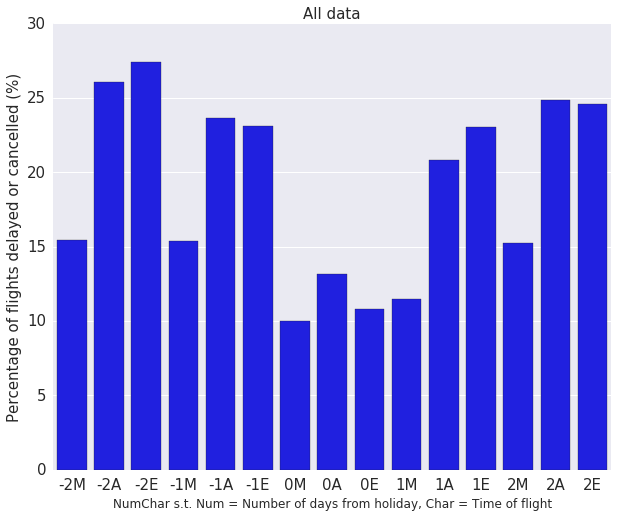

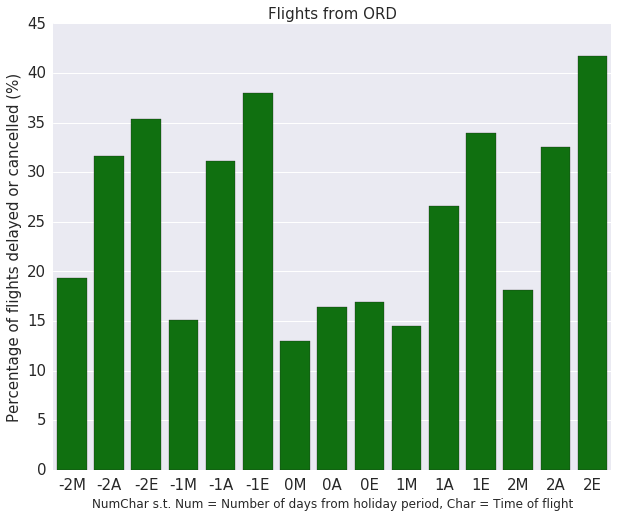

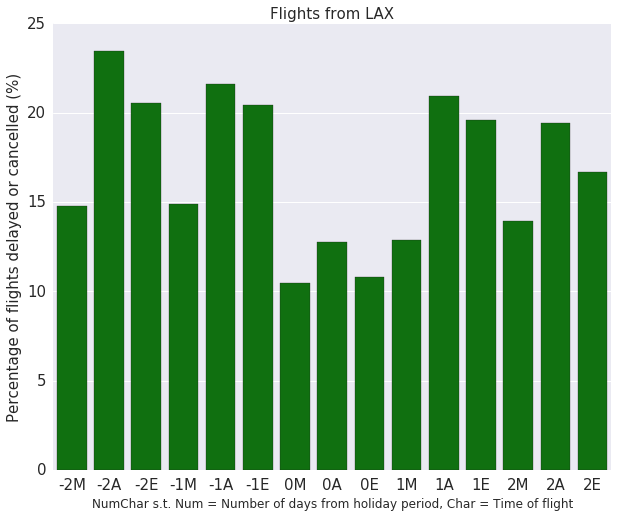

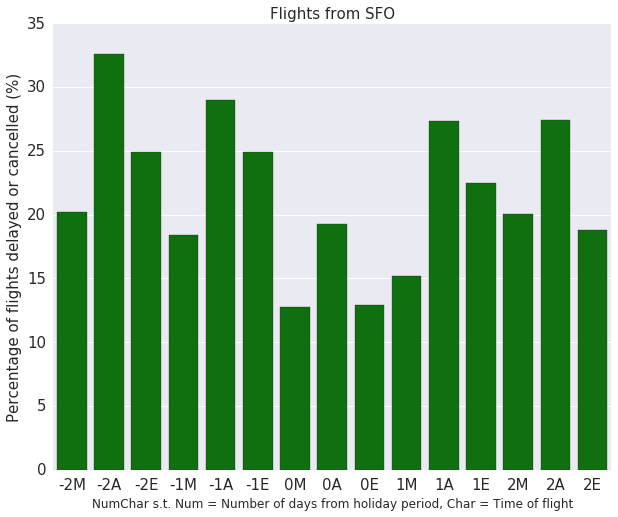

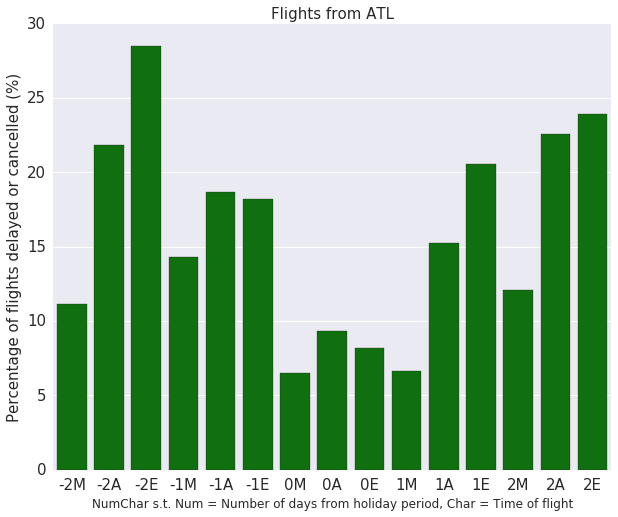

In [946]:
import itertools

y = []
x = range(-2,3)
t= ['M','A','E']
for i in x:
    for j in t:
        y.append(air_df_trunc[(air_df_trunc.CLASS == i) & (air_df_trunc.TIME_OF_DAY == j)].DEL_OR_CANC.mean()*100)
x2 = itertools.chain.from_iterable(itertools.repeat(i,3) for i in x)
zip_list = zip(x2, itertools.cycle(t))
zip_list_str = zip([str(i[0]) for i in zip_list], [i[1] for i in zip_list])


LABEL = [''.join(w) for w in zip_list_str]
xplot = range(len(x)*len(t))

fig = plt.figure(figsize=(10, 8))
#plt.bar(xplot, y, color="blue",align='center')
sns.barplot(xplot, y,color="blue")
plt.xticks(xplot, LABEL,fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('NumChar s.t. Num = Number of days from holiday, Char = Time of flight',fontsize=12)
plt.ylabel('Percentage of flights delayed or cancelled (%)',fontsize=15)
plt.title('All data',fontsize=15)
plt.show()

for orig in air_df_trunc.ORIGIN.unique().tolist():
    y=[]
    for i in x:
        for j in t:
            y.append(air_df_trunc[(air_df_trunc.CLASS == i) & (air_df_trunc.TIME_OF_DAY == j) & (air_df_trunc.ORIGIN ==orig)].DEL_OR_CANC.mean()*100)
            # By default, null values are skipped in the computation of the percentage of delays
            
    x2 = itertools.chain.from_iterable(itertools.repeat(i,3) for i in x)
    zip_list = zip(x2, itertools.cycle(t))
    zip_list_str = zip([str(i[0]) for i in zip_list], [i[1] for i in zip_list])


    LABEL = [''.join(w) for w in zip_list_str]
    xplot = range(len(x)*len(t))

    fig = plt.figure(figsize=(10, 8))
    #plt.bar(xplot, y, color="blue",align='center')
    sns.barplot(xplot, y,color="green")
    plt.xticks(xplot, LABEL,fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('NumChar s.t. Num = Number of days from holiday period, Char = Time of flight',fontsize=12)
    plt.ylabel('Percentage of flights delayed or cancelled (%)',fontsize=15)
    plt.title('Flights from ' + orig,fontsize=15)
    plt.show()

The trend seems to be reasonable clear. During the holidays, the number of delays becomes low perhaps due to low crowds and hence low stress on the system. Given that a flight is delayed more than 15 minutes, I'll also visualize the average delay. Code is copied from above and needs to be streamlined.

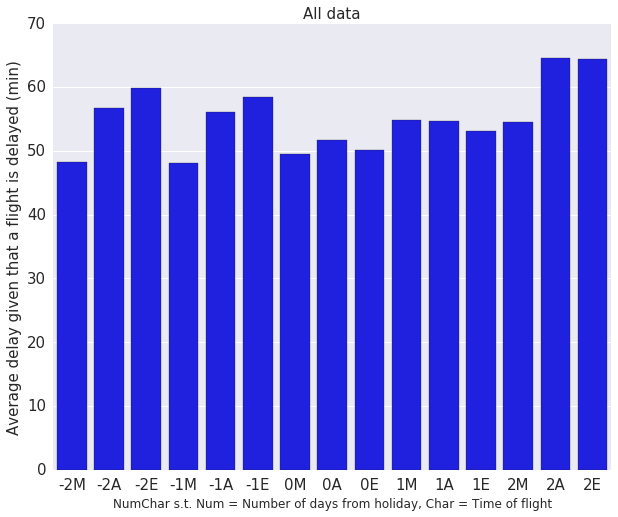

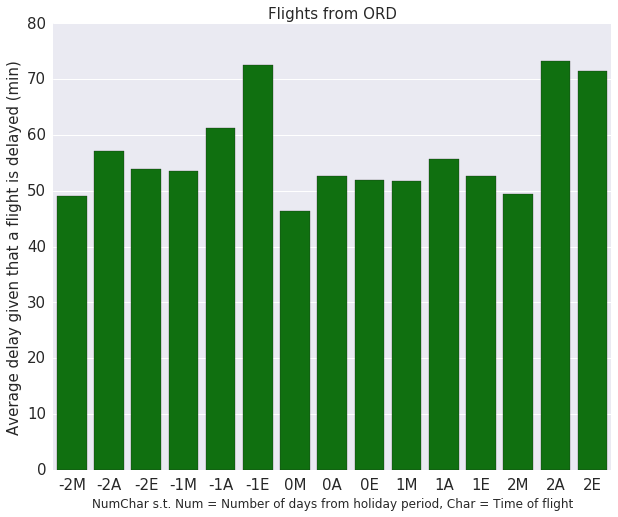

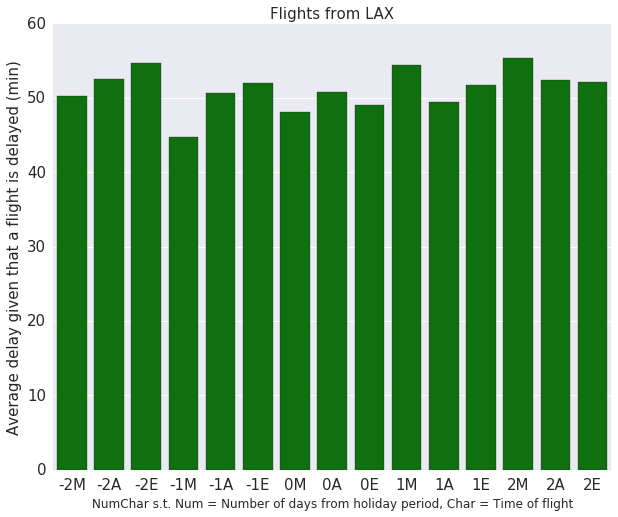

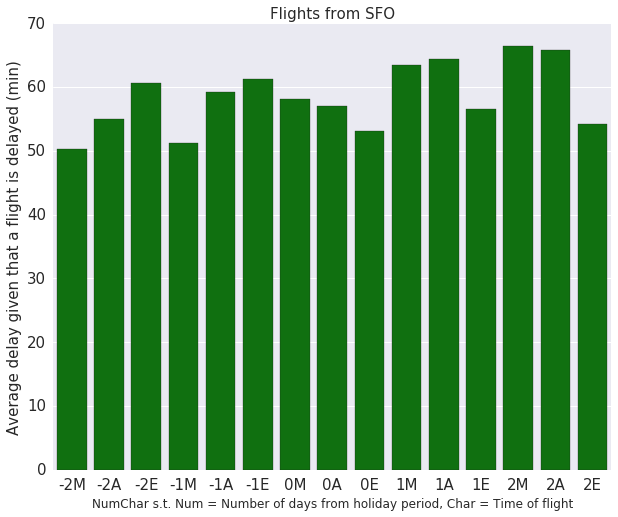

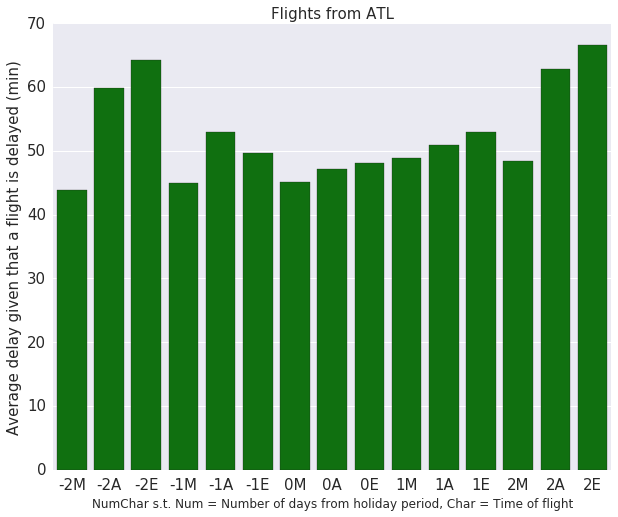

In [947]:
import itertools

y = []
x = range(-2,3)
t= ['M','A','E']
for i in x:
    for j in t:
        y.append(air_df_trunc[(air_df_trunc.CLASS == i) & (air_df_trunc.TIME_OF_DAY == j) & (air_df_trunc.DEL_OR_CANC == 1)].ARR_DELAY_NEW.mean())
x2 = itertools.chain.from_iterable(itertools.repeat(i,3) for i in x)
zip_list = zip(x2, itertools.cycle(t))
zip_list_str = zip([str(i[0]) for i in zip_list], [i[1] for i in zip_list])


LABEL = [''.join(w) for w in zip_list_str]
xplot = range(len(x)*len(t))

fig = plt.figure(figsize=(10, 8))
#plt.bar(xplot, y, color="blue",align='center')
sns.barplot(xplot, y,color="blue")
plt.xticks(xplot, LABEL,fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('NumChar s.t. Num = Number of days from holiday, Char = Time of flight',fontsize=12)
plt.ylabel('Average delay given that a flight is delayed (min)',fontsize=15)
plt.title('All data',fontsize=15)
plt.show()

for orig in air_df_trunc.ORIGIN.unique().tolist():
    y=[]
    for i in x:
        for j in t:
            y.append(air_df_trunc[(air_df_trunc.CLASS == i) & (air_df_trunc.TIME_OF_DAY == j) & (air_df_trunc.ORIGIN ==orig) & (air_df_trunc.DEL_OR_CANC == 1)].ARR_DELAY_NEW.mean())
            # By default, null values are skipped in the computation of the percentage of delays
            
    x2 = itertools.chain.from_iterable(itertools.repeat(i,3) for i in x)
    zip_list = zip(x2, itertools.cycle(t))
    zip_list_str = zip([str(i[0]) for i in zip_list], [i[1] for i in zip_list])


    LABEL = [''.join(w) for w in zip_list_str]
    xplot = range(len(x)*len(t))

    fig = plt.figure(figsize=(10, 8))
    #plt.bar(xplot, y, color="blue",align='center')
    sns.barplot(xplot, y,color="green")
    plt.xticks(xplot, LABEL,fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('NumChar s.t. Num = Number of days from holiday period, Char = Time of flight',fontsize=12)
    plt.ylabel('Average delay given that a flight is delayed (min)',fontsize=15)
    plt.title('Flights from ' + orig,fontsize=15)
    plt.show()

This is a bit more interesting. Given that a flight is delayed, the average delay doesn't seem to change much with time! 

## Machine learning and analysis

For this part of the analysis, I'll truncate the dataframe even further to keep only the values that I need

In [958]:
cols_to_keep = ['ORIGIN','ARR_DELAY_NEW','DEL_OR_CANC','CLASS','TIME_OF_DAY']
air_df_trunc_2 = air_df_trunc[cols_to_keep]

Now that I've extracted everything I want, I'll drop the columms I don't need

In [959]:
air_df_trunc_2 = air_df_trunc_2.dropna()

### Logistic regression classifier to predict if a flight will get delayed

First, I perform a logistic regression to predict whether a flight will be delayed or cancelled given the number of days before/after a holiday period. First, I encode my categorical variables using One hot encoding

In [960]:
from sklearn.preprocessing import OneHotEncoder

feature_list = ['CLASS','TIME_OF_DAY','ORIGIN']

M = air_df_trunc_2[feature_list]

# Declare replacement rules to get all classes as integers. Can use dictionary OneHotEncoding from sklearn, but takes longer
rep_dict = {}
rep_dict['TIME_OF_DAY'] =  {'M': 0, 'A': 1, 'E': 2}
rep_dict['ORIGIN'] = {'ATL' : 0, 'LAX' : 1, 'ORD' : 2, 'SFO' : 3}
rep_dict['CLASS'] = {-2: 4, -1 : 3} #, 0:0, 1:1, 2:2 (0,1,2 remain same)

M = M.replace(to_replace = rep_dict)
enc = OneHotEncoder()

X = enc.fit_transform(M)
y = air_df_trunc_2.DEL_OR_CANC

In [961]:
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

def crossValidate(model,param_grid,X,y,scores):

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        grid = GridSearchCV(model, param_grid, cv=7, scoring=score)
        grid.fit(X_train,y_train)

        print("Best parameters set found on development set:")
        print()
        print(grid.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        for params, mean_score, scores in grid.grid_scores_:
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the training set.")
        print("The scores are computed on the test set.")
        print()
        y_true, y_pred = y_test, grid.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

Since the set is skewed to the negative class, I perform weight balancing of each data point in the logistic regression classifier

In [978]:
logreg = linear_model.LogisticRegression(class_weight='balanced')
Cvals = [0.0001, 0.001, 0.01,0.1,1]
param_grid = dict(C=Cvals)

scores = ['precision', 'recall','roc_auc']
crossValidate(logreg,param_grid,X,y,scores)

# clf_rf = RandomForestClassifier(n_jobs=-1)
# nvals = [20,50]
# param_grid = dict(n_estimators =nvals)
# crossValidate(clf_rf,param_grid,X,y)

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'C': 0.01}
()
Grid scores on development set:
()
0.235 (+/-0.003) for {'C': 0.0001}
0.235 (+/-0.003) for {'C': 0.001}
0.236 (+/-0.003) for {'C': 0.01}
0.236 (+/-0.003) for {'C': 0.1}
0.236 (+/-0.003) for {'C': 1}
()
Detailed classification report:
()
The model is trained on the training set.
The scores are computed on the test set.
()
             precision    recall  f1-score   support

        0.0       0.88      0.55      0.68     55882
        1.0       0.23      0.63      0.34     11988

avg / total       0.76      0.57      0.62     67870

()
# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'C': 0.001}
()
Grid scores on development set:
()
0.653 (+/-0.011) for {'C': 0.0001}
0.662 (+/-0.019) for {'C': 0.001}
0.650 (+/-0.033) for {'C': 0.01}
0.650 (+/-0.033) for {'C': 0.1}
0.650 (+/-0.033) for {'C': 1}
()
Detailed classification report:
()
The model 

I performed some cross validation and found that regularization doesn't really help. I confirmed this below when I used multiple values of C, and the precision, recall and specificity stay almost constant

In [979]:
for cvals in [0.001,0.01,0.1,1]:
    logreg = linear_model.LogisticRegression(class_weight='balanced',C=cvals)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    L = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    
    print "# C = " +str(cvals)
    
    print 'Null Accuracy is ' + str(max(np.mean(y_test),1-np.mean(y_test))*100) + '%'

    confusion = metrics.confusion_matrix(y_test, y_pred)
    print confusion
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print "Sensitivity = Recall = %f" % metrics.recall_score(y_test, y_pred)
    print "Specificity = %f" % (TN / float(TN + FP))
    print "Precision = %f" % metrics.precision_score(y_test, y_pred)


# C = 0.001
Null Accuracy is 82.0730808899%
[[29066 26637]
 [ 3962  8205]]
Sensitivity = Recall = 0.674365
Specificity = 0.521803
Precision = 0.235492
# C = 0.01
Null Accuracy is 82.0642404597%
[[29303 26394]
 [ 4121  8052]]
Sensitivity = Recall = 0.661464
Specificity = 0.526115
Precision = 0.233757
# C = 0.1
Null Accuracy is 82.0730808899%
[[29188 26515]
 [ 4071  8096]]
Sensitivity = Recall = 0.665406
Specificity = 0.523993
Precision = 0.233914
# C = 1
Null Accuracy is 82.2896714307%
[[29300 26550]
 [ 4015  8005]]
Sensitivity = Recall = 0.665973
Specificity = 0.524620
Precision = 0.231660


The precision is very poor. However, I would like my recall value to be high since I want to correctly identify as many delays as possible. Therefore, the classifier works for now, although there is plenty of work to be done to improve it. As can be seen below, the AUC is just above 60%. Perhaps other classifiers might work better, which will be future work

AUC = 63.2044550197%


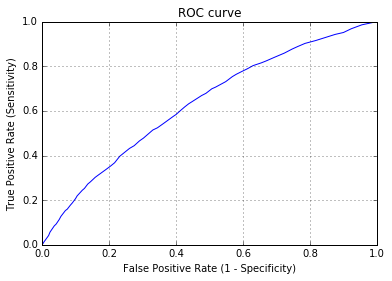

In [813]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# IMPORTMANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print "AUC = " + str(metrics.roc_auc_score(y_test, y_pred_prob)*100) + "%"

I use this logistic regression model to compare the propensity of delays for each airport at different times of the day. Although the probability output by the logistic regression isn't very accurate (since classification accuracy is poor), it provides a relative measure for propensity of delay between the different airports

In [980]:
city_pred_df = pd.DataFrame()

for orig in ['ATL','LAX','ORD','SFO']:
    l=0
    for i in range(-2,3):
        for j in ['M','A','E']:
            city_pred_df= city_pred_df.append(pd.Series([orig,LABEL[l],predictProb(i,j,orig,logreg)]),ignore_index=True)
            l+=1
            
city_pred_df= city_pred_df.rename(columns={0: 'Origin City', 1: 'xlabel',2:'prop'});

def predictProb(cl,tod,orig,logreg):
    class_dict = {-2: 4, -1 : 3, 0:0, 1:1, 2:2}
    tod_dict = {'M': 0, 'A': 1, 'E': 2}
    orig_dict = {'ATL' : 0, 'LAX' : 1, 'ORD' : 2, 'SFO' : 3}

    x = np.zeros(12)
    
    x[class_dict[cl]] = 1
    x[tod_dict[tod] + len(class_dict)] = 1
    x[orig_dict[orig] + len(class_dict) + len(tod_dict)] = 1
    return logreg.predict_proba(x)[:, 1][0]*100

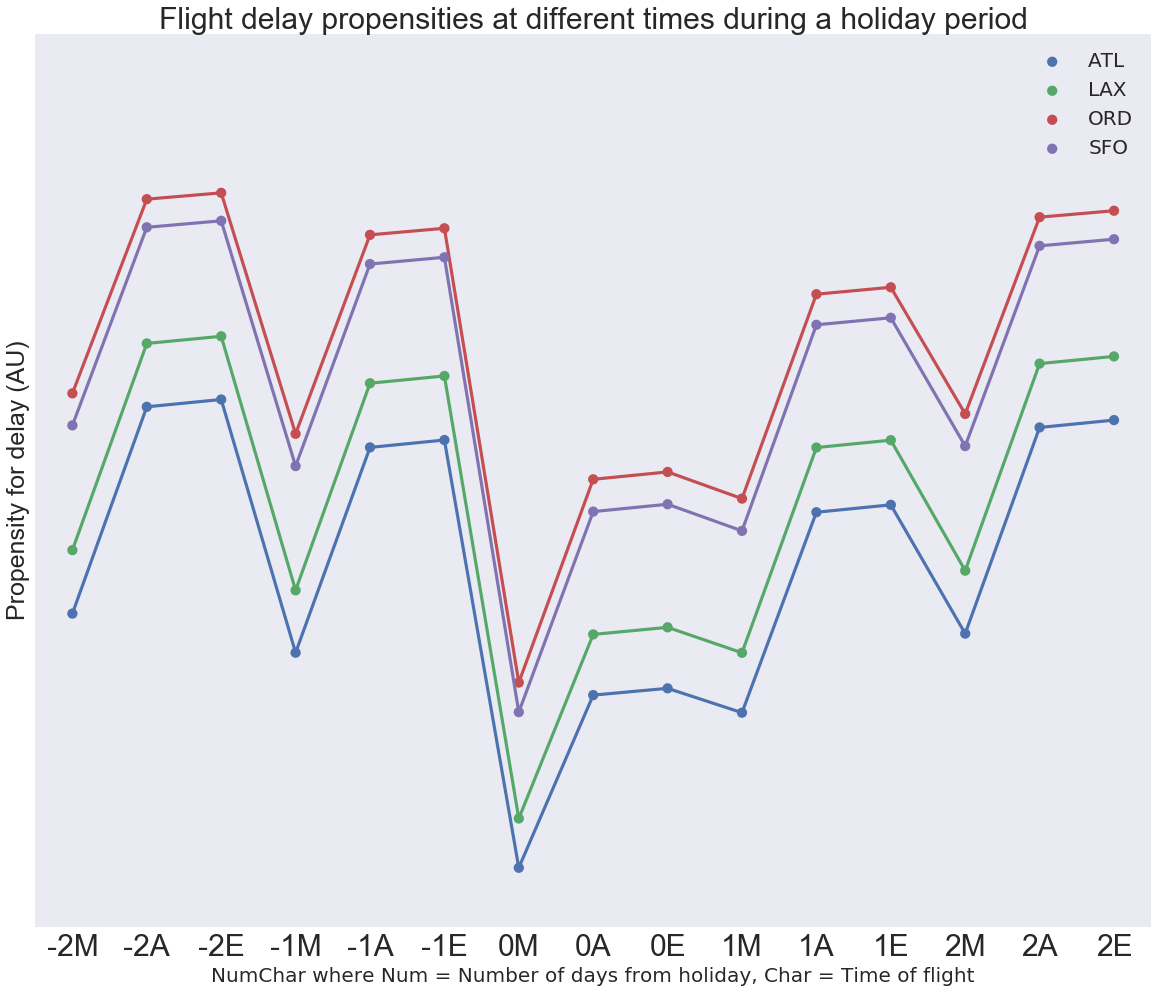

In [1005]:
fig = plt.figure(figsize=(20, 16))
sns.pointplot(x='xlabel',y='prop',hue='Origin City',data=city_pred_df)
plt.xticks(fontsize = 30)
plt.xlabel('NumChar where Num = Number of days from holiday, Char = Time of flight',fontsize=20)
plt.title('Flight delay/cancellation propensities at different times during a holiday period',fontsize=30)
frame1 = plt.gca()
plt.ylabel('Propensity for delay (AU)',fontsize=25)
plt.legend(fontsize = 20)
frame1.axes.get_yaxis().set_ticks([])
plt.savefig('DelayProp.png')
plt.show()


We can see the trend is always to have low propensity for delays in the morning, which increases as the day goes on. Unsurprisingly, the lowest propensity for delay is during the holiday period, and the trend is rather V-shaped. What is interesting is that Atlanta has the lowest propensity for delay among the 4, even though it is by far the busiest airport. Chicago O'hare is the highest, followed surprisingly closely by San Francisco

### Linear Regression to predict delay times

I now want to use a linear regression model to predict if a flight is delayed, what is the expected delay for a given airport at a given time on a given day within the holiday period. First, I truncate the data even further

In [964]:
air_df_trunc_3 = air_df_trunc_2[air_df_trunc_2.DEL_OR_CANC == 1]

I then perform one hot encoding on the categorical features of this truncated data

In [971]:
feature_list = ['CLASS','TIME_OF_DAY','ORIGIN']

M_lin = air_df_trunc_3[feature_list]

M_lin = M_lin.replace(to_replace = rep_dict)
enc = OneHotEncoder()

X_lin = enc.fit_transform(M_lin)
y_lin = air_df_trunc_3.ARR_DELAY_NEW

In [973]:
# from sklearn import linear_model

# Create linear regression object
linreg = linear_model.LinearRegression()
X_train,X_test,y_train,y_test = train_test_split(X_lin,y_lin,test_size=0.2)


In [974]:
L = linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)

In [975]:
print('Coefficients: \n', linreg.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((linreg.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linreg.score(X_test, y_test))

('Coefficients: \n', array([-3.96549753, -1.6432121 ,  6.78576735, -1.18955596, -0.39427981,
       -4.46327931,  1.79450725,  2.261994  , -1.9477603 , -4.00196378,
        1.89834475,  3.64460126]))
Residual sum of squares: 3341.71
Variance score: 0.01


The linear regression model can certainly be improved, but let's see what it predicted

In [990]:
delay_pred_df = pd.DataFrame()

for orig in ['ATL','LAX','ORD','SFO']:
    l=0
    for i in range(-2,3):
        for j in ['M','A','E']:
            delay_pred_df= delay_pred_df.append(pd.Series([orig,LABEL[l],predictVal(i,j,orig,linreg)]),ignore_index=True)
            l+=1
            
delay_pred_df= delay_pred_df.rename(columns={0: 'Origin City', 1: 'xlabel',2:'delay'});



In [987]:
def predictVal(cl,tod,orig,linreg):
    class_dict = {-2: 4, -1 : 3, 0:0, 1:1, 2:2}
    tod_dict = {'M': 0, 'A': 1, 'E': 2}
    orig_dict = {'ATL' : 0, 'LAX' : 1, 'ORD' : 2, 'SFO' : 3}

    x = np.zeros(12)
    
    x[class_dict[cl]] = 1
    x[tod_dict[tod] + len(class_dict)] = 1
    x[orig_dict[orig] + len(class_dict) + len(tod_dict)] = 1
    return linreg.predict(x)[0]

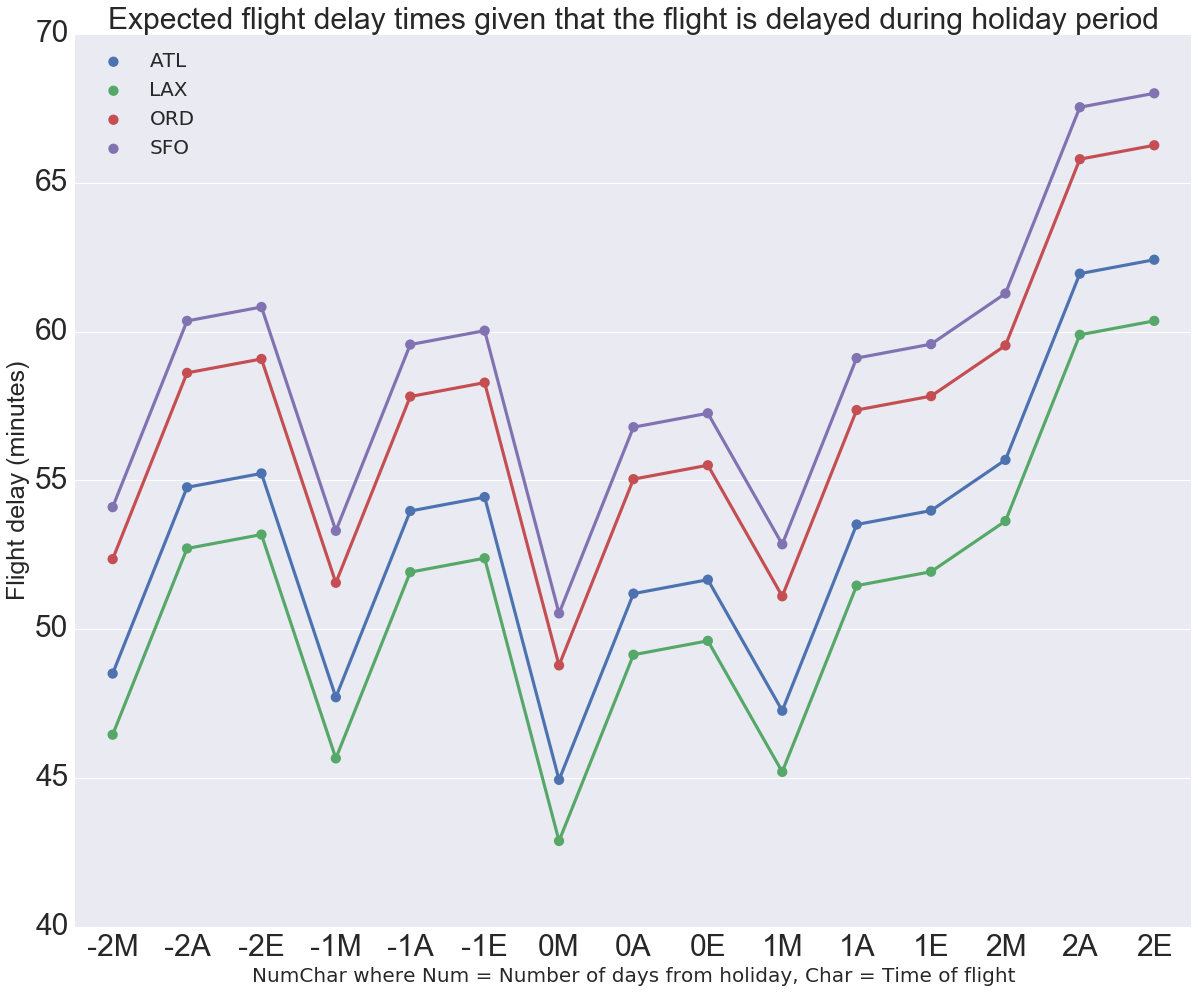

In [1014]:
fig = plt.figure(figsize=(20, 16))
sns.pointplot(x='xlabel',y='delay',hue='Origin City',data=delay_pred_df,legend=False)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('NumChar where Num = Number of days from holiday, Char = Time of flight',fontsize=20)
plt.title('Expected flight delay times given that the flight is delayed during holiday period',fontsize=30)
frame1 = plt.gca()
plt.ylabel('Flight delay (minutes)',fontsize=25)
plt.legend(fontsize = 20,loc='upper left')
plt.savefig('DelayTimes.png')
plt.show()


We can see that the flight delay forms a reasonably consistent pattern during the holiday period, with an unusual spike towards the end. Again, San Francisco and O'Hare are the biggest culprits for the longest predicted delay (given that a flight is delayed). As usual, this value dips in the morning. The differences between the lowest and highest point might only be 15 minutes, but with a more accurate predictor, 15 minutes could be the difference between choosing a flight with a 35 minute connection and one with a 50 minute connection while booking

## Future work

1. Collect more data
2. Improve classification and prediction accuracy, possibly explore other techniques and feature engineering
3. Possibly study entire dataset to get a better prediction of the (potentially unusual) behavior during the holiday period
4. With more data, perform analysis over more features (such as airline)

Once we have good predictors, a user can be confident of knowing how likely his flight will be delayed and if so, for how long. The question needs to be carefully thought through so that the right model can be used to perform this prediction.

Eventually, it would also be nice to build predictive models of expected airport security line delays during the holiday period, and even expected commute time to airport from different zip codes (Possibly Google maps API?). Then, a user will have an end-to-end prediction of what delays he is likely to face on a given day at a given time on a particular airline at a certain airport before booking his trip. This way, a user can make more informed decisions before booking one's trip.